In [1]:
import sys
import joblib
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
import shap
from metrics import get_scores

In [2]:
sys.path.append('../archive/src')

In [3]:
preprocessed = joblib.load("../tmp/preprocessed.joblib")
X = preprocessed["X"]
y = preprocessed["y"]
n_trg_names = preprocessed["n_trg_names"]
transformer = preprocessed["transformer"]

In [4]:
def custom_metric(y, t):
    from scipy.stats import spearmanr
    score = spearmanr(t, y, nan_policy="propagate")[0]
    return 'rho', score, True

In [5]:
# from sklearn.utils import parallel_backend
# parallel_backend("multiprocessing", n_jobs=4)

In [6]:
from lightgbm import LGBMRanker
from estimator import MultitaskRegressor
from estimator import RankerWrapper

max_labels = int(n_trg_names * 2)

estimator = LGBMRanker(
    #device="gpu",
    boosting_type="dart",
    objective="lambdarank",
    metric="None",
    label_gain=np.arange(max_labels),
    lambdarank_truncation_level=max_labels,
    num_iterations=1000//2,
    #early_stopping_round=10,
    num_leaves=2**6-1,
    learning_rate=0.1,
    max_bin=128,
    #max_drop=0,
    #bagging_freq=1,
    #bagging_fraction=0.8,
    #feature_fraction=0.5,
    #lambdarank_norm=False,
    #seed=123,
    #min_data_in_leaf=100,
    #min_sum_hessian_in_leaf=1e-2,
    n_jobs=4,
)

estimator = RankerWrapper(estimator)

estimator = MultitaskRegressor(estimator)

In [7]:
def limit_range(X, y, year):
    from_date = pd.Timestamp(f"{year}-03-27")
    to_date = pd.Timestamp(f"{year}-05-15")
    dates = X.index.get_level_values("base_date")
    range_cnd = (dates >= from_date) & (dates <= to_date)
    #range_cnd &= X.index.get_level_values("prediction_target") == True
    
    X["high_20"] = y[:, 0]
    X["low_20"] = y[:, 1]
    X = X[range_cnd].groupby("Local Code").nth(-1)
    y = X[["high_20", "low_20"]].values
    X.drop(["high_20", "low_20"], axis=1, inplace=True)
    return X, y

def cv(estimator, X, y, w=None):
    from sklearn.model_selection import KFold
    from sklearn.base import clone
    
    estimators = []
    scores = []
    
    years =  X.index.get_level_values("base_date").year
    uniq_years = np.array([2017, 2018, 2019, 2020])
    
    kf = KFold(n_splits=uniq_years.shape[0], shuffle=False)
    
    print(uniq_years)
    for tr_idx, ts_idx in kf.split(uniq_years):
        tr_years = uniq_years[tr_idx]
        ts_years = uniq_years[ts_idx]
        tr_mask = years.isin(tr_years)
        ts_mask = years.isin(ts_years)
        tr_X = X[tr_mask].copy()
        ts_X = X[ts_mask].copy()
        tr_y = y[tr_mask]
        ts_y = y[ts_mask]
        if w is None:
            tr_w = None
        else:
            tr_w = w[tr_mask]
        #ts_w = w[ts_mask]
        
        ts_year = ts_years[0]
        
        ts_X, ts_y = limit_range(ts_X, ts_y, ts_year)
        
        #print(tr_idx)
        #print(f"train: {tr_dates.min()} - {tr_dates.max()} #{tr_y.shape[0]}")
        print(f"test: {ts_year} #{ts_y.shape[0]}")
        estimator = clone(estimator)
        estimator.fit(tr_X, tr_y, sample_weight=tr_w, eval_set=[(ts_X, ts_y)], eval_metric=custom_metric)
        
        pr_y = estimator.predict(ts_X)
#         base_act_price = ts_X["feat_actual_price"].values[:, None]
#         pr_price = (pr_y + 1) * base_act_price
#         print(pr_price)
#         pr_price = np.round(pr_price)
#         pr_y = pr_price / base_act_price - 1
        
        #print(ts_X.shape, ts_y.shape)
        #pr_y = np.clip(pr_y, -1.0, None)
        score = get_scores(ts_y, pr_y)
        print(score)
        estimators.append(estimator)
        scores.append(score)
        
    return estimators, scores


estimators, scores = cv(estimator, X, y, None)

[2017 2018 2019 2020]
test: 2017 #3160


Found `num_iterations` in params. Will use it instead of argument
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[1]	valid_0's rho: 0.255811
[2]	valid_0's rho: 0.342694
[3]	valid_0's rho: 0.358174
[4]	valid_0's rho: 0.36513
[5]	valid_0's rho: 0.370154
[6]	valid_0's rho: 0.375888
[7]	valid_0's rho: 0.376988
[8]	valid_0's rho: 0.376059
[9]	valid_0's rho: 0.378202
[10]	valid_0's rho: 0.38093
[11]	valid_0's rho: 0.382844
[12]	valid_0's rho: 0.382738
[13]	valid_0's rho: 0.386917
[14]	valid_0's rho: 0.38969
[15]	valid_0's rho: 0.392794
[16]	valid_0's rho: 0.394497
[17]	valid_0's rho: 0.396869
[18]	valid_0's rho: 0.399789
[19]	valid_0's rho: 0.401162
[20]	valid_0's rho: 0.402894
[21]	valid_0's rho: 0.402735
[22]	valid_0's rho: 0.404986
[23]	valid_0's rho: 0.405758
[24]	valid_0's rho: 0.405809
[25]	valid_0's rho: 0.407755
[26]	valid_0's rho: 0.409888
[27]	valid_0's rho: 0.411344
[28]	valid_0's rho: 0.411451
[29]	valid_0's rho: 0.411884
[30]	valid_0's rho: 0.4132
[31]	valid_0's rho: 0.414196
[32]	valid_0's rho: 0.413529
[33]	valid_0's rho: 0.413409
[34]	valid_0's rho: 0.41704
[35]	valid_0's rho: 0.416546


In [8]:
sc_df = pd.DataFrame(scores, columns=["rho_high", "rho_low", "score"])
sc_df

,rho_high,rho_low,score
0,0.444420,0.508891,0.549857
1,0.424258,0.519220,0.562629
2,0.369576,0.435134,0.716508
3,0.488869,0.390580,0.632647


In [9]:
pd.concat([sc_df.mean().rename("mean"), sc_df.std().rename("std")], axis=1)

,mean,std
rho_high,0.431781,0.049480
rho_low,0.463456,0.061338
score,0.615410,0.076596


In [20]:
joblib.dump(
    {"transformer": transformer, "estimators": estimators},
    "../archive/model/model.joblib",
    compress=False
)

['../archive/model/model.joblib']

In [11]:
base_date = X.index.get_level_values("base_date")
pb_mask = ("2020-01-01" <= base_date) & (base_date <= "2020-11-30")
#pb_mask &= X.index.get_level_values("prediction_target") == True

pb_p = estimators[-1].predict(X[pb_mask])
get_scores(y[pb_mask], pb_p),pb_mask.sum()

((0.43448816874285706, 0.15939142889361274, 1.0264264011093296), 16327)

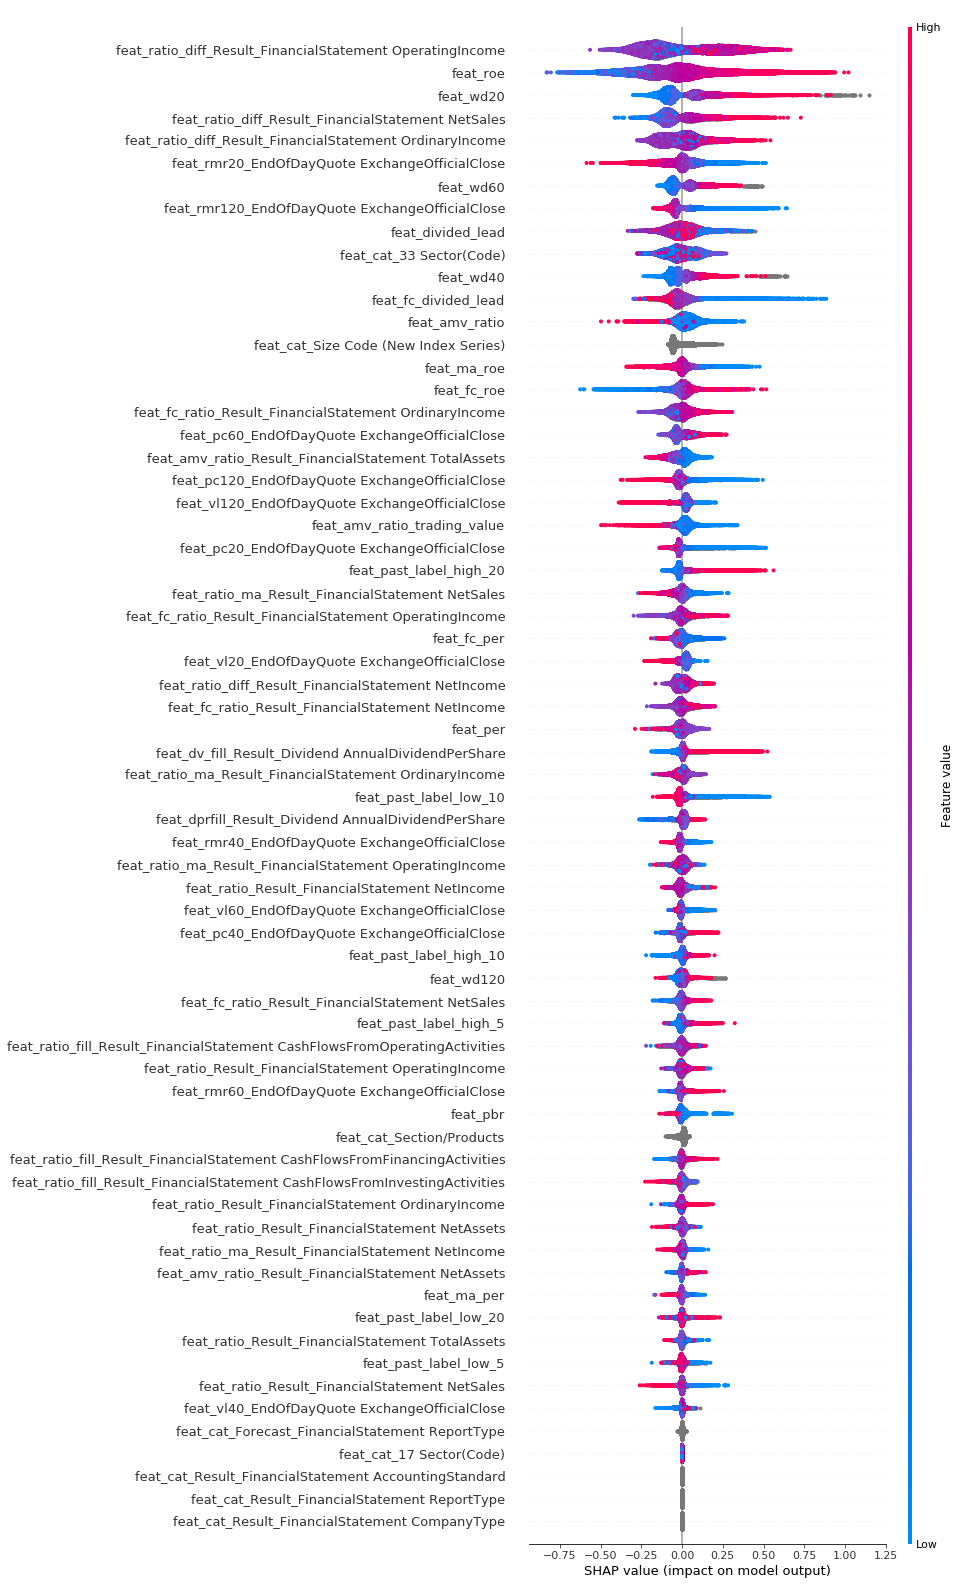

In [12]:
explainer = shap.TreeExplainer(estimators[-1].estimator_high_.estimator)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, max_display=X.shape[1])

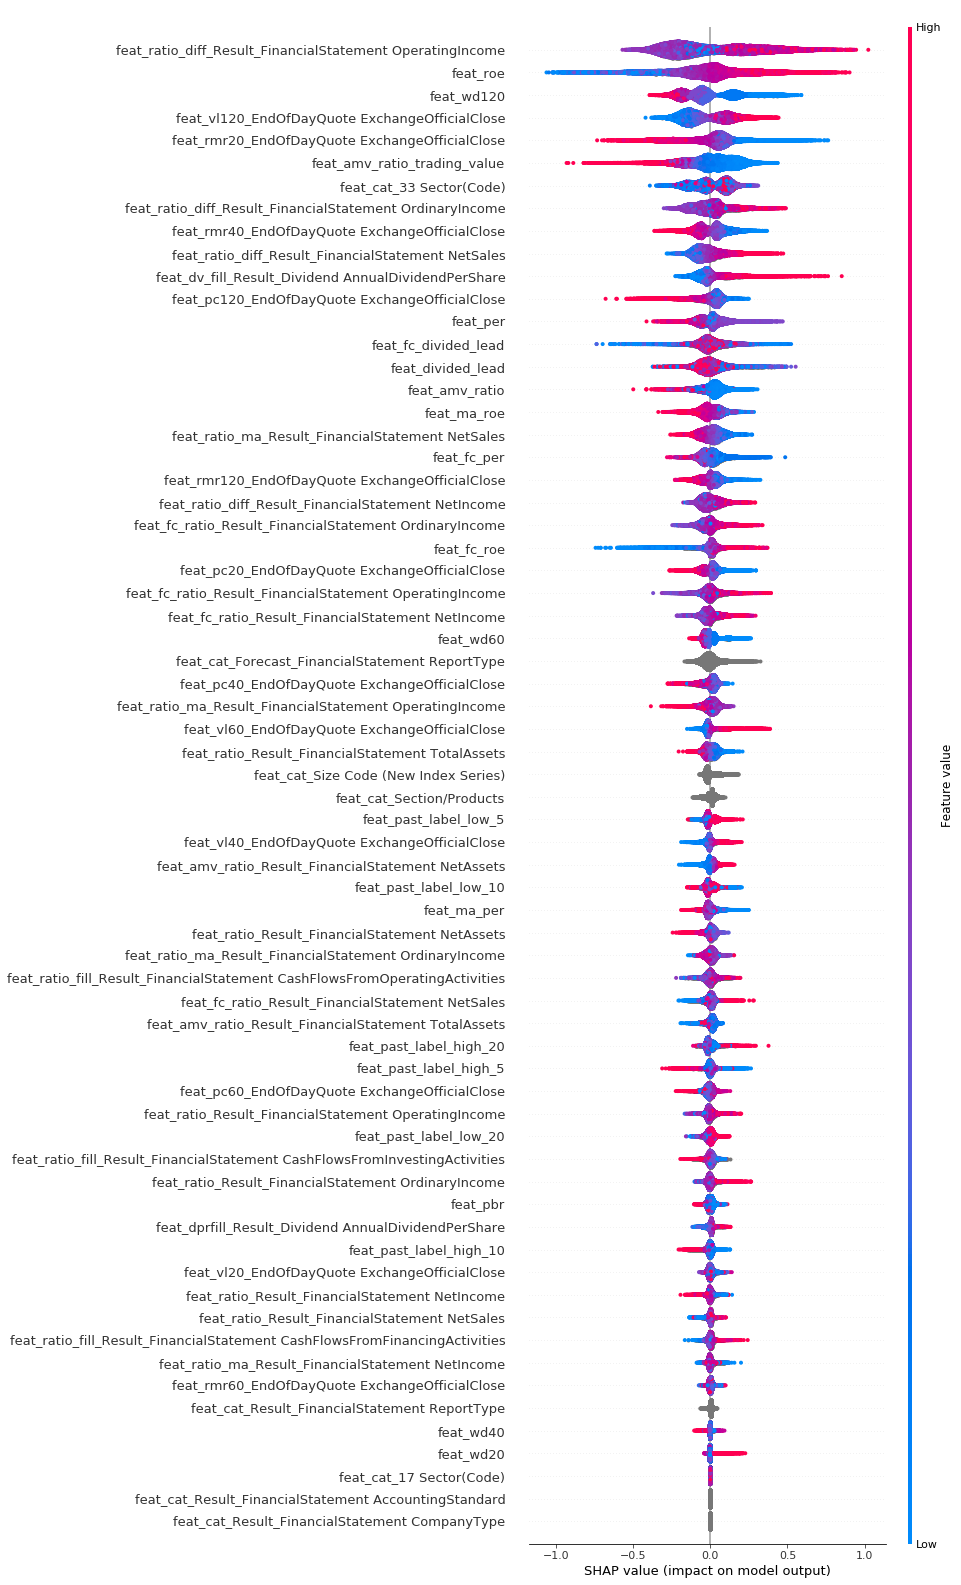

In [13]:
explainer = shap.TreeExplainer(estimators[-1].estimator_low_.estimator)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, max_display=X.shape[1])

In [14]:
na_ratio = X.isna().mean()
na_ratio[na_ratio>0.5]

Series([], dtype: float64)

In [15]:
X.index.get_level_values("base_date") + pd.DateOffset(days=1)

DatetimeIndex(['2017-02-11', '2017-02-18', '2017-05-12', '2017-08-05',
               '2017-11-07', '2018-02-10', '2018-05-11', '2018-08-04',
               '2018-11-06', '2019-02-09',
               ...
               '2019-08-01', '2019-10-31', '2019-11-01', '2020-02-01',
               '2020-05-14', '2020-08-01', '2020-10-30', '2020-10-31',
               '2021-01-29', '2021-01-30'],
              dtype='datetime64[ns]', name='base_date', length=68562, freq=None)

In [16]:
X.index.get_level_values("base_date")

DatetimeIndex(['2017-02-10', '2017-02-17', '2017-05-11', '2017-08-04',
               '2017-11-06', '2018-02-09', '2018-05-10', '2018-08-03',
               '2018-11-05', '2019-02-08',
               ...
               '2019-07-31', '2019-10-30', '2019-10-31', '2020-01-31',
               '2020-05-13', '2020-07-31', '2020-10-29', '2020-10-30',
               '2021-01-28', '2021-01-29'],
              dtype='datetime64[ns]', name='base_date', length=68562, freq=None)

In [17]:
dtypes = X.dtypes
dtypes[dtypes == "category"]

feat_cat_Result_FinancialStatement AccountingStandard    category
feat_cat_Result_FinancialStatement ReportType            category
feat_cat_Result_FinancialStatement CompanyType           category
feat_cat_Forecast_FinancialStatement ReportType          category
feat_cat_Section/Products                                category
feat_cat_33 Sector(Code)                                 category
feat_cat_17 Sector(Code)                                 category
feat_cat_Size Code (New Index Series)                    category
dtype: object

In [18]:
X.columns[X.columns.str.startswith("feat_cat_")]

Index(['feat_cat_Result_FinancialStatement AccountingStandard',
       'feat_cat_Result_FinancialStatement ReportType',
       'feat_cat_Result_FinancialStatement CompanyType',
       'feat_cat_Forecast_FinancialStatement ReportType',
       'feat_cat_Section/Products', 'feat_cat_33 Sector(Code)',
       'feat_cat_17 Sector(Code)', 'feat_cat_Size Code (New Index Series)'],
      dtype='object')

In [19]:
import  sklearn
sklearn.__version__

'0.20.3'